Train STM on incels.is forum data with it being from top users as a covariate

Also see run_stm.r script

In [14]:
.libPaths()

[1] "/home/mamille3/white_supremacist_networks/conda_env/lib/R/library"

# Load, prepare data

In [1]:
library(jsonlite)

path = '../../data/incels/processed_comments_user_info.jsonl'
data <- stream_in(file(path))
nrow(data)

opening file input connection.



 Imported 6248230 records. Simplifying...


closing file input connection.



[1] 6248230

In [2]:
summary(data)

   username         top5percent_eigen_user  parsed_date       
 Length:6248230     Mode :logical          Min.   :1.510e+12  
 Class :character   FALSE:3196174          1st Qu.:1.542e+12  
 Mode  :character   TRUE :3052056          Median :1.574e+12  
                                           Mean   :1.569e+12  
                                           3rd Qu.:1.594e+12  
                                           Max.   :1.618e+12  
                                           NA's   :34236      
   content         
 Length:6248230    
 Class :character  
 Mode  :character  
                   
                   
                   
                   

In [6]:
# Sample
set.seed(9)
samp = data[sample(nrow(data),1000),]
print(nrow(samp))

[1] 1000


# Run STM

## Search for number of topics
Is in stm_searchk.r

In [1]:
library(stm)

stm v1.3.6 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com



In [ ]:
# Settings

num_topics = c(20, 30, 50, 100, 200)
max_iters <- 100
do_stem <- TRUE
min_df <- 100 # minimum document frequency for words
covariates_str <- 'sourcexday'

cat('Processing data...\n')
# processed <- textProcessor(samp$text, stem=do_stem, metadata=samp,
# 		verbose=TRUE)
processed <- textProcessor(filtered$text, stem=do_stem, metadata=filtered,
		verbose=TRUE)
out <- prepDocuments(processed$documents, processed$vocab, processed$meta,
					lower.thresh=min_df)

Processing data...


In [29]:
colnames(out$meta)

[1] "id"         "text"       "word_count" "dataset"    "source"    
 [6] "domain"     "timestamp"  "date"       "day"        "visibility"

In [8]:
# Run
storage <- searchK(documents = out$documents,
                vocab = out$vocab,
                K = num_topics,
                max.em.its = max_iters,
                prevalence =~ source * day,
                # prevalence =~ source,
				verbose=TRUE,
                data = out$meta)

Beginning Spectral Initialization 
	 Calculating the gram matrix...
	 Finding anchor words...
 	....................
	 Recovering initialization...
 	.....
Initialization complete.
........................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 1 (approx. per word bound = -6.135) 
........................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 2 (approx. per word bound = -5.911, relative change = 3.647e-02) 
........................................................................................................
Completed E-Step (0 seconds). 
Completed M-Step. 
Completing Iteration 3 (approx. per word bound = -5.764, relative change = 2.481e-02) 
........................................................................................................
Completed E-Step 

In [2]:
# Load (from stm_searchk.r)
path <- '../models/search_white_supremacist_users_2012-07-14_thru_2017-08-31_stm_sourcexday_100it_100mindf.rds'
storage <- readRDS(path)

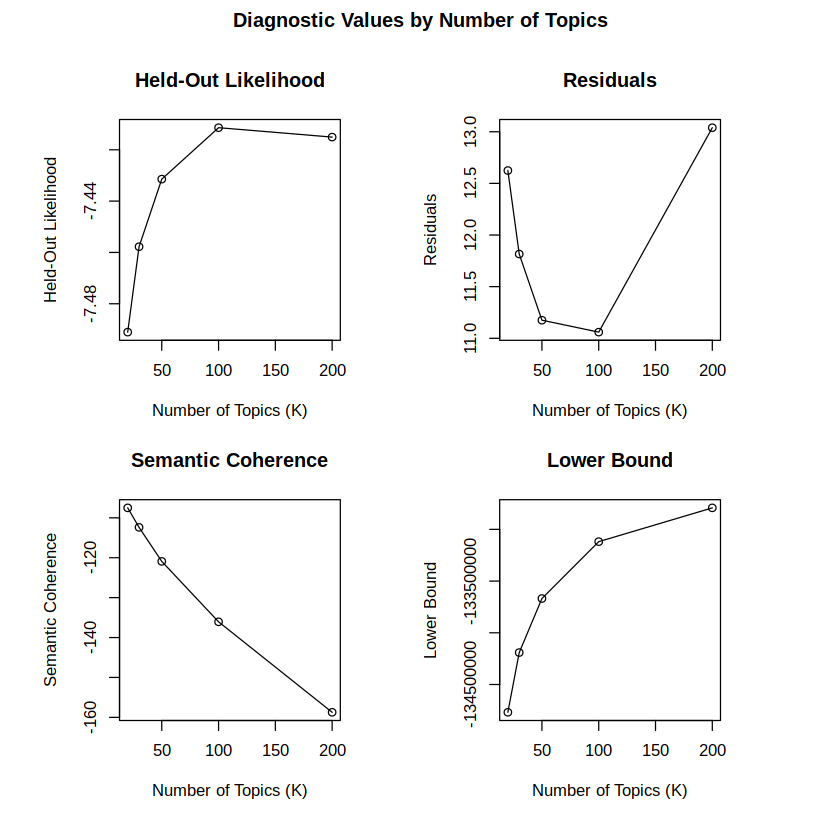

In [3]:
# Visualize
plot(storage)

In [14]:
storage$results

K,heldout,residual,bound,lbound,em.its
<list>,<list>,<list>,<list>,<list>,<list>
20,-6.301058,1.726084,-118817.4,-118775.1,10
30,-6.289544,1.738935,-116449.5,-116374.8,10
50,-6.514954,2.088289,-114609.5,-114461,10
100,-6.564826,-41.19424,-116175,-115811.3,10
200,-6.60738,-0.3733665,-121179.8,-120316.6,10


In [17]:
storage$semcoh

NULL

In [11]:
class(storage)

[1] "searchK"

## Fixed number of topics

In [8]:
library('stm')

stm v1.3.6 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com



In [13]:
# Settings

num_topics <- 30
max_iters <- 10
do_stem <- TRUE
min_df <- 50 # minimum document frequency for words
covariates_str <- 'top5percent_eigen_user'

cat('Processing data...\n')
# processed <- textProcessor(samp$content, stem=do_stem, metadata=samp,
processed <- textProcessor(data$content, stem=do_stem, metadata=data,
		verbose=TRUE)
out <- prepDocuments(processed$documents, processed$vocab, processed$meta,
					lower.thresh=min_df)

Processing data...
Building corpus... 
Converting to Lower Case... 
Removing punctuation... 
Removing stopwords... 
Removing numbers... 
Stemming... 


ERROR: Error in `[<-.data.frame`(`*tmp*`, , tag, value = c("WØLF", "GermaniaIncelia", : replacement has 1000 rows, data has 6248230


In [12]:
cat('\nEstimating STM...\n')
model <- stm(documents = out$documents,
                vocab = out$vocab,
                K = num_topics,
                max.em.its = max_iters,
                prevalence =~ top5percent_eigen_user,
                 content = NULL,
				verbose=TRUE,
                data = out$meta)


Estimating STM...
Beginning Spectral Initialization 


ERROR: Error in stm.init(documents, settings): Spectral initialization cannot be used for the overcomplete case (K greater than or equal to number of words in vocab)


### Save out

In [14]:
outpath <- sprintf('../models/white_supremacist_stm_%s_%dtopics_%dit_%dmindf.rds', covariates_str, num_topics, max_iters, min_df)
cat(sprintf('Saved model to %s\n', outpath))
saveRDS(model, outpath)

Saved model to ../models/white_supremacist_stm_source+day_30topics_10it_50mindf.rds


# Plot, investigate topics 

In [1]:
# Load model
corpus_name <- 'white_supremacist_users_2012-07-14_thru_2017-08-31'
num_topics <- 100
max_iters <- 100
do_stem <- TRUE
min_df <- 100 # minimum document frequency for words
covariates_str <- 'sourcexday'

path <- sprintf('../models/%s_stm_%s_%dtopics_%dit_%dmindf.rds', corpus_name, covariates_str, num_topics, max_iters, min_df)
# path <- sprintf('../models/%s_orig_stm_%s_%dtopics_%dit_%dmindf.rds', corpus_name, covariates_str, num_topics, max_iters, min_df)
model <- readRDS(path)

In [2]:
library("stm")

l <- labelTopics(model, n=10)
l

stm v1.3.6 successfully loaded. See ?stm for help. 
 Papers, resources, and other materials at structuraltopicmodel.com



Topic 1 Top Words:
 	 Highest Prob: cross, republ, slav, turkey, turk, gypsi, hungarian, hungari, serb, serbian 
 	 FREX: turk, gypsi, hungarian, serb, serbian, serbia, turkish, albanian, romanian, balkan 
 	 Lift: belgrad, bulgaria, croat, gypsi, hungarian, kosovo, magyar, serbia, slovak, tito 
 	 Score: serb, serbian, albanian, hungarian, как, turk, serbia, slav, что, turkey 
Topic 2 Top Words:
 	 Highest Prob: level, usual, train, fit, bodi, strong, low, physic, huge, amount 
 	 FREX: fit, improv, usual, mad, proper, level, mouth, bare, bigger, weight 
 	 Lift: stoop, gym, taller, width, workout, muscl, steroid, boob, teeth, smarter 
 	 Score: level, train, low, fit, fat, bodi, physic, improv, size, usual 
Topic 3 Top Words:
 	 Highest Prob: read, also, interest, book, http, found, lol, write, surpris, sourc 
 	 FREX: http, lol, edit, book, read, yep, write, surpris, nope, text 
 	 Lift: ironmarchorgindexphp, nbu, http, supris, blackshirt, yep, anti-racist, lol, nope, edit 
 	 Score

In [3]:
# Save out for ORA attributes
top_terms = paste(l$frex[,1], l$frex[,2], l$frex[,3])
top_terms = as.data.frame(top_terms)
# top_terms

top_terms$topic = 1:num_topics
top_terms

top_terms,topic
<chr>,<int>
turk gypsi hungarian,1
fit improv usual,2
http lol edit,3
part lost larg,4
believ truth truli,5
pic redpil kek,6
dog song cat,7
freedom free suck,8
site websit internet,9


In [4]:
# Save out to add attribute to ORA
path <- sprintf('../tmp/%s_stm_%s_%dtopics_%dit_%dmindf_top3_terms.csv', corpus_name, covariates_str, num_topics, max_iters, min_df)
write.csv(top_terms, path)
path

[1] "../tmp/white_supremacist_users_2012-07-14_thru_2017-08-31_stm_sourcexday_100topics_100it_100mindf_top3_terms.csv"

In [5]:
topicnames = paste(sprintf('Topic %s: ', l$topicnums), l$frex[,1], l$frex[,2], l$frex[,3], sep=' ')
topicnames

[1] "Topic 1:  turk gypsi hungarian"         
  [2] "Topic 2:  fit improv usual"             
  [3] "Topic 3:  http lol edit"                
  [4] "Topic 4:  part lost larg"               
  [5] "Topic 5:  believ truth truli"           
  [6] "Topic 6:  pic redpil kek"               
  [7] "Topic 7:  dog song cat"                 
  [8] "Topic 8:  freedom free suck"            
  [9] "Topic 9:  site websit internet"         
 [10] "Topic 10:  ill doctor patient"          
 [11] "Topic 11:  christma day happi"          
 [12] "Topic 12:  nice friend glad"            
 [13] "Topic 13:  agre reason argument"        
 [14] "Topic 14:  trump hillari clinton"       
 [15] "Topic 15:  conquer centuri histori"     
 [16] "Topic 16:  just know think"             
 [17] "Topic 17:  yes sweden swedish"          
 [18] "Topic 18:  thank sorri stormfront"      
 [19] "Topic 19:  irish spain spanish"         
 [20] "Topic 20:  jail sentenc charg"          
 [21] "Topic 21:  amp wwwyoutubecomwatch nigga"
 [22] "Topic 22:  attent media coverag"        
 [23] "Topic 23:  cri hors beg"                
 [24] "Topic 24:  african africa indian"       
 [25] "Topic 25:  exampl experi perfect"       
 [26] "Topic 26:  christian cathol pagan"      
 [27] "Topic 27:  australian town citi"        
 [28] "Topic 28:  game ever watch"             
 [29] "Topic 29:  https dream everywher"       
 [30] "Topic 30:  number test research"        
 [31] "Topic 31:  director committe robert"    
 [32] "Topic 32:  mexican hit walk"            
 [33] "Topic 33:  wrong fault blame"           
 [34] "Topic 34:  step forward bulli"          
 [35] "Topic 35:  ’re ’ve ’ll"                 
 [36] "Topic 36:  sleep hang warm"             
 [37] "Topic 37:  time back long"              
 [38] "Topic 38:  ideolog marxist social"      
 [39] "Topic 39:  good lot thing"              
 [40] "Topic 40:  fuck shit nigger"            
 [41] "Topic 41:  will need take"              
 [42] "Topic 42:  black neighborhood baltimor" 
 [43] "Topic 43:  line along bottom"           
 [44] "Topic 44:  children child kid"          
 [45] "Topic 45:  mention drug forgot"         
 [46] "Topic 46:  poland polish german"        
 [47] "Topic 47:  holocaust camp duke"         
 [48] "Topic 48:  idiot stupid crap"           
 [49] "Topic 49:  ironmarch fascist intro"     
 [50] "Topic 50:  racist white non"            
 [51] "Topic 51:  make mistak disagre"         
 [52] "Topic 52:  legal illeg enforc"          
 [53] "Topic 53:  film paint movi"             
 [54] "Topic 54:  economi china debt"          
 [55] "Topic 55:  san que con"                 
 [56] "Topic 56:  troll stormer alex"          
 [57] "Topic 57:  jew rabbi semit"             
 [58] "Topic 58:  und afd ist"                 
 [59] "Topic 59:  evola esoter philosophi"     
 [60] "Topic 60:  canada canadian gospel"      
 [61] "Topic 61:  muslim countri demograph"    
 [62] "Topic 62:  stop messag petit"           
 [63] "Topic 63:  stori interview fake"        
 [64] "Topic 64:  kill fire dead"              
 [65] "Topic 65:  sport real footbal"          
 [66] "Topic 66:  hate swastika label"         
 [67] "Topic 67:  fbi splc infiltr"            
 [68] "Topic 68:  emb rockwel propaganda"      
 [69] "Topic 69:  pay tax money"               
 [70] "Topic 70:  gay homosexu porn"           
 [71] "Topic 71:  brother hail stand"          
 [72] "Topic 72:  women hair male"             
 [73] "Topic 73:  eat drink meat"              
 [74] "Topic 74:  ask question answer"         
 [75] "Topic 75:  group organ movement"        
 [76] "Topic 76:  seem pretti much"            
 [77] "Topic 77:  soviet war fight"            
 [78] "Topic 78:  traitor scum deserv"         
 [79] "Topic 79:  cultur european ethnic"      
 [80] "Topic 80:  refuge asylum migrant"       
 [81] "Topic 81:  genet race gene"             
 [82] "Topic 82:  peopl other person"          
 [83] "Topic 83:  natur thus mere"             
 [84] "Topic 84:  

In [14]:
# Annotate topics possibly related to chan style
chan_topics = c(6, 40, 48, 56, 78, 93)
topicnames[chan_topics]

[1] "Topic 6:  pic redpil kek"       "Topic 40:  fuck shit nigger"   
[3] "Topic 48:  idiot stupid crap"   "Topic 56:  troll stormer alex" 
[5] "Topic 78:  traitor scum deserv" "Topic 93:  tfw chan shitpost"

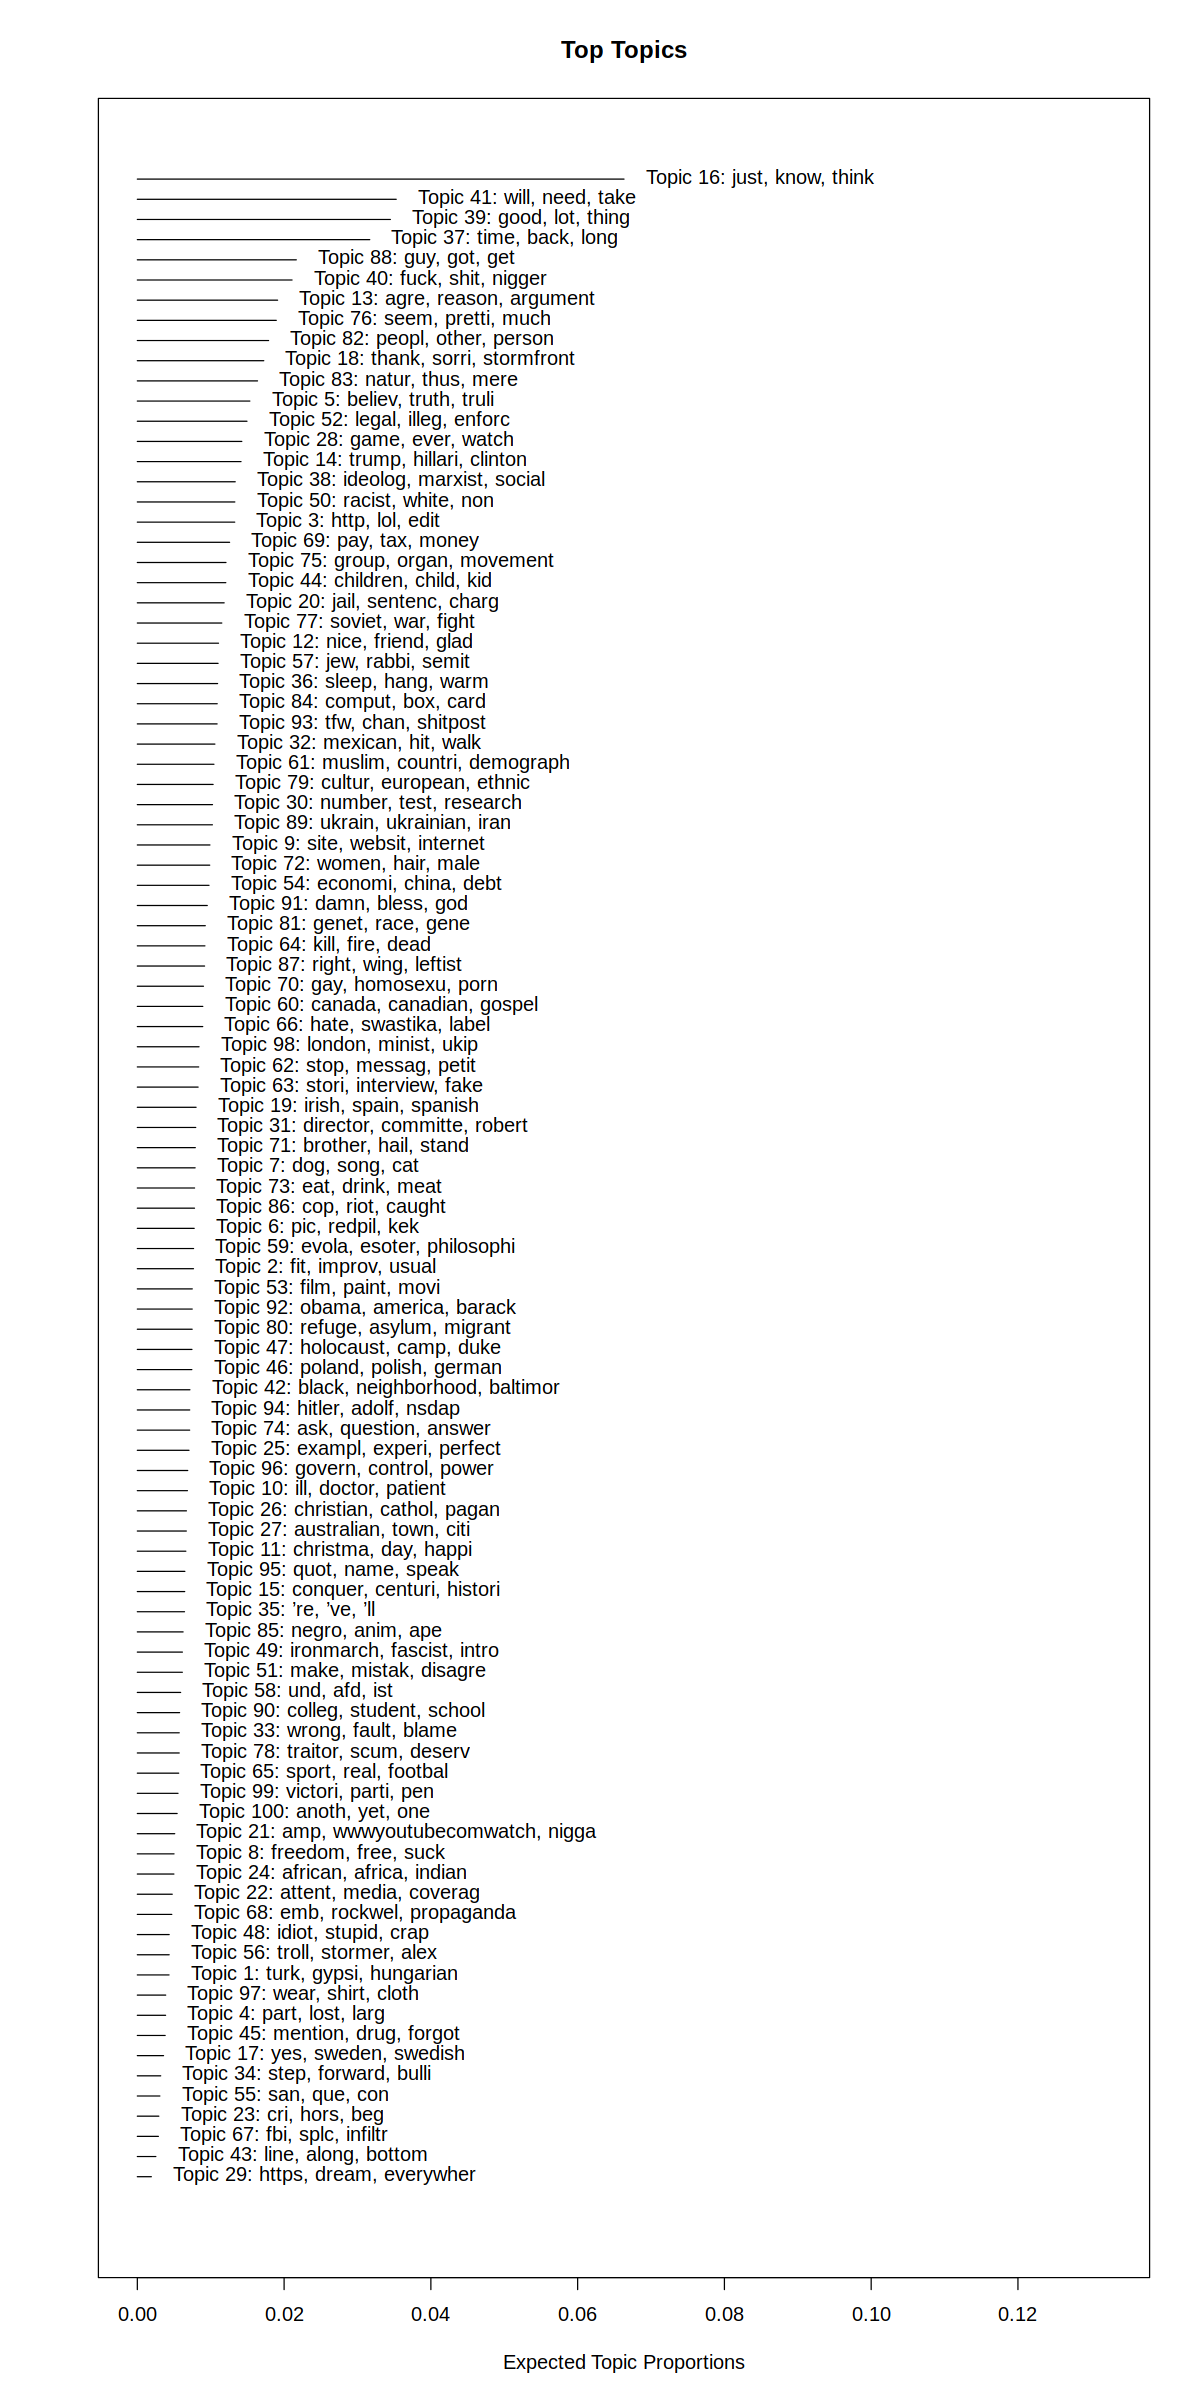

In [13]:
options(repr.plot.width=10, repr.plot.height=20)
plot(model, type='summary', labeltype='frex')

In [14]:
# Load processed docs
out <- readRDS(sprintf('../tmp/processed_%s.rds', corpus_name))
# processed <- readRDS(sprintf('../tmp/processed_%s.rds', corpus_name))
nrow(out$meta)

[1] 547046

In [35]:
colnames(out$meta)

[1] "id"         "text"       "word_count" "dataset"    "source"    
[6] "domain"     "timestamp"  "date"       "day"

In [36]:
levels(out$meta$source)

[1] "4chan"         "daily_stormer" "ironmarch"     "stormfront"   
[5] "twitter"

In [37]:
library(forcats)

# Try adding in a public/private field

out$meta$visibility = fct_collapse(out$meta$source, 'public'=c('twitter', 'daily_stormer'), 'private'=c('4chan', 'ironmarch', 'stormfront'))
levels(out$meta$visibility)

[1] "private" "public"

## Top documents for topics

In [18]:
library(stm)
findThoughts(model, out$meta$text, topics=15, n=10)


 Topic 15: 
 	 niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers niggers 

# Estimate effects

In [8]:
effect <- estimateEffect(1:num_topics ~ source * s(day), model, meta=out$meta, uncertainty='Global') # takes a very long time for full dataset (should put in script)
summary(effect)

Warning message in estimateEffect(1:num_topics ~ source * s(day), model, meta = out$meta, :
“Covariate matrix is singular.  See the details of ?estimateEffect() for some common causes.
             Adding a small prior 1e-5 for numerical stability.”



Call:
estimateEffect(formula = 1:num_topics ~ source * s(day), stmobj = model, 
    metadata = out$meta, uncertainty = "Global")


Topic 1:

Coefficients:
                              Estimate Std. Error t value Pr(>|t|)
(Intercept)                  -0.008262   1.671050  -0.005    0.996
sourcedaily_stormer           0.058632   1.670845   0.035    0.972
sourceironmarch               0.019278   1.671043   0.012    0.991
sourcestormfront              0.019584   1.671044   0.012    0.991
sourcetwitter                 0.060292   1.671170   0.036    0.971
s(day)1                       0.002294   5.247036   0.000    1.000
s(day)2                       0.017491   1.670660   0.010    0.992
s(day)3                       0.014704   1.671249   0.009    0.993
s(day)4                       0.015633   1.671000   0.009    0.993
s(day)5                       0.015388   1.671076   0.009    0.993
s(day)6                       0.015254   1.671044   0.009    0.993
s(day)7                       0.014944  

In [38]:
# Try an effect based on covariate not included in model estimation
num_topics = 30
effect <- estimateEffect(1:num_topics ~ visibility * s(day), model, meta=out$meta, uncertainty='Global') # takes a very long time for full dataset (should put in script)
summary(effect)


Call:
estimateEffect(formula = 1:num_topics ~ visibility * s(day), 
    stmobj = model, metadata = out$meta, uncertainty = "Global")


Topic 1:

Coefficients:
                            Estimate Std. Error t value Pr(>|t|)    
(Intercept)                0.0111016  0.0004953  22.414  < 2e-16 ***
visibilitypublic           0.0210629  0.0082407   2.556  0.01059 *  
s(day)1                    0.0005962  0.0009527   0.626  0.53147    
s(day)2                    0.0004509  0.0006895   0.654  0.51317    
s(day)3                    0.0011839  0.0007437   1.592  0.11141    
s(day)4                   -0.0016154  0.0006367  -2.537  0.01118 *  
s(day)5                    0.0009551  0.0006858   1.393  0.16374    
s(day)6                   -0.0032183  0.0006336  -5.079 3.80e-07 ***
s(day)7                   -0.0021416  0.0006620  -3.235  0.00122 ** 
s(day)8                   -0.0038839  0.0006972  -5.571 2.54e-08 ***
s(day)9                   -0.0032253  0.0006955  -4.637 3.53e-06 ***
s(day)10    

In [39]:
# Save out (since takes forever for a large dataset)
# path <- sprintf('../tmp/%s_stm_%s_%dtopics_%dit_%dmindf_effect.rds', corpus_name, covariates_str, num_topics, max_iters, min_df)
path <- sprintf('../tmp/%s_stm_%s_%dtopics_%dit_%dmindf_effect_visibility.rds', corpus_name, covariates_str, num_topics, max_iters, min_df)
saveRDS(effect, path)

In [7]:
# Load effect
path <- sprintf('../tmp/%s_stm_%s_%dtopics_%dit_%dmindf_effect.rds', corpus_name, covariates_str, num_topics, max_iters, min_df)
effect <- readRDS(path)

In [21]:
levels(out$meta$source)

[1] "4chan"      "discord"    "ironmarch"  "stormfront" "twitter"

## Plot effects of time (day)

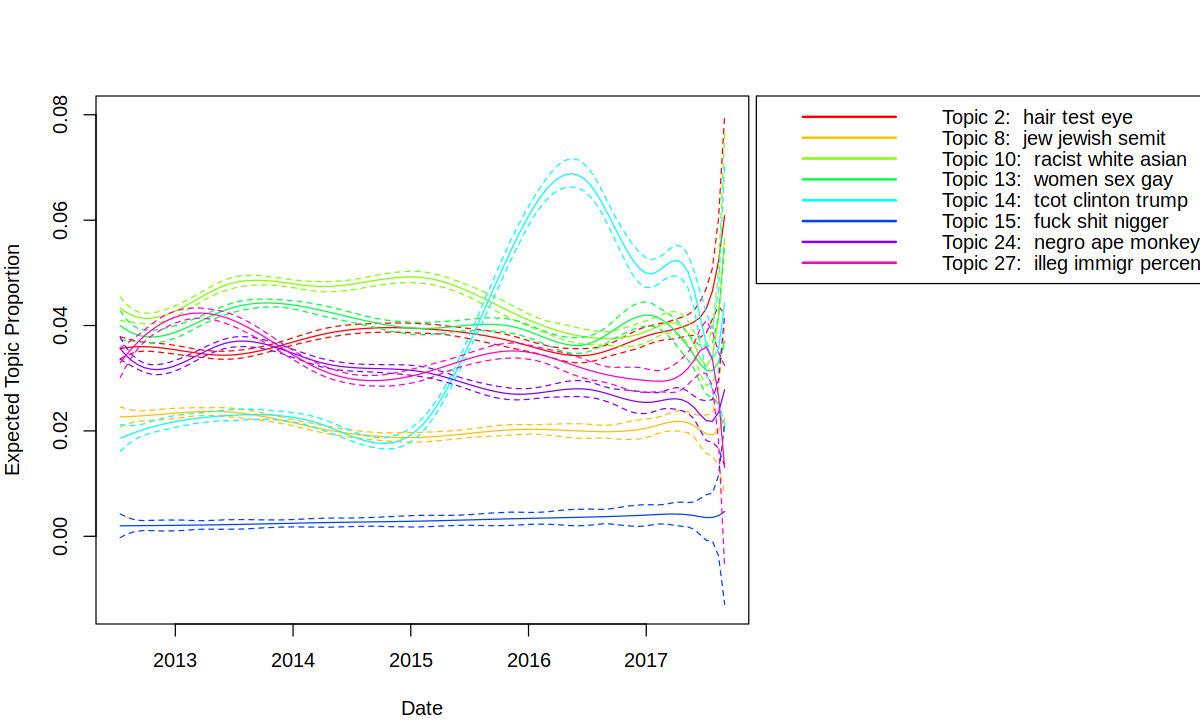

In [17]:
# yearseq = 2002:2020
yearseq = 2013:2017
offset = as.integer(as.Date(sprintf('%s-01-01', min(yearseq))) - min(out$meta$date)) # to align the year ticks
# topic = 9
topics = c(2,8,10,13,14,15,24,27)
# topics = 1:num_topics

library('repr')
options(repr.plot.width=10, repr.plot.height=6)
par(mar = c(4, 4, 4, 18.8),                                  # Specify par parameters
    xpd = TRUE)
plot(effect, 
     model = model,
    covariate='day', 
    # topics=c(topic), 
    topics=topics,
    method = 'continuous', 
     xlab='Date',
     xaxt = 'n',
     # labeltype = 'frex',
    # main = sprintf('Topic: %s', topicnames[topic]), 
     printlegend= FALSE
     )
axis(1, at=((yearseq-min(yearseq))*365) + offset, labels=yearseq)
legend("topright", inset=c(-1.4,0) , topicnames[topics], lwd=2, col=rainbow(length(topics)))
# legend("topright", inset=c(-1.8,0) , topicnames[topics], lwd=2, col=rainbow(length(topics)))

In [12]:
print(min(out$meta$date))
print(max(out$meta$date))

[1] "2012-07-14"
[1] "2017-08-31"


In [19]:
# yearseq = seq(from=min(filtered$date), to=max(filtered$date), by = 'year')
yearseq = 2013:2017
yearseq

(yearseq - min(yearseq))*365

[1] 2013 2014 2015 2016 2017

[1]    0  365  730 1095 1460

In [20]:
offset = as.integer(as.Date(sprintf('%s-01-01', min(yearseq))) - min(out$meta$date))
offset

[1] 171

In [21]:
((yearseq - min(yearseq))*365) + offset

[1]  171  536  901 1266 1631

In [88]:
rainbow(8)

[1] "#FF0000" "#FFBF00" "#80FF00" "#00FF40" "#00FFFF" "#0040FF" "#8000FF"
[8] "#FF00BF"

In [86]:
palette()

[1] "black"   "#DF536B" "#61D04F" "#2297E6" "#28E2E5" "#CD0BBC" "#F5C710"
[8] "gray62"

## Plot effects of day x dataset

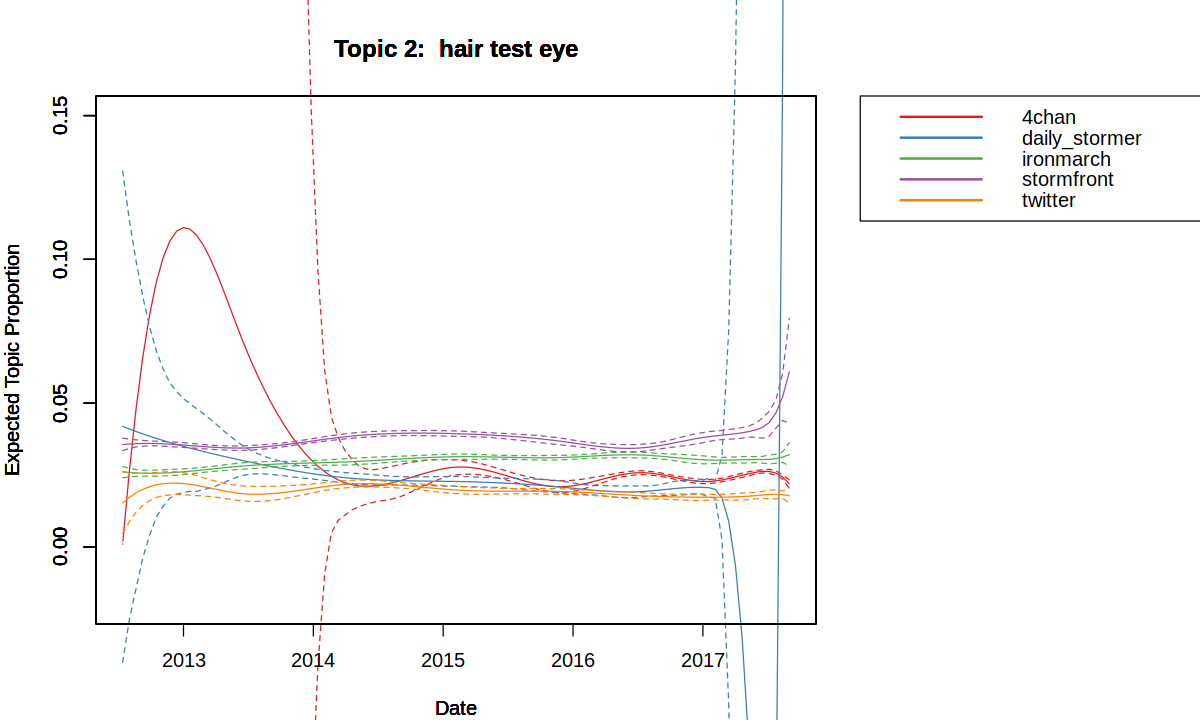

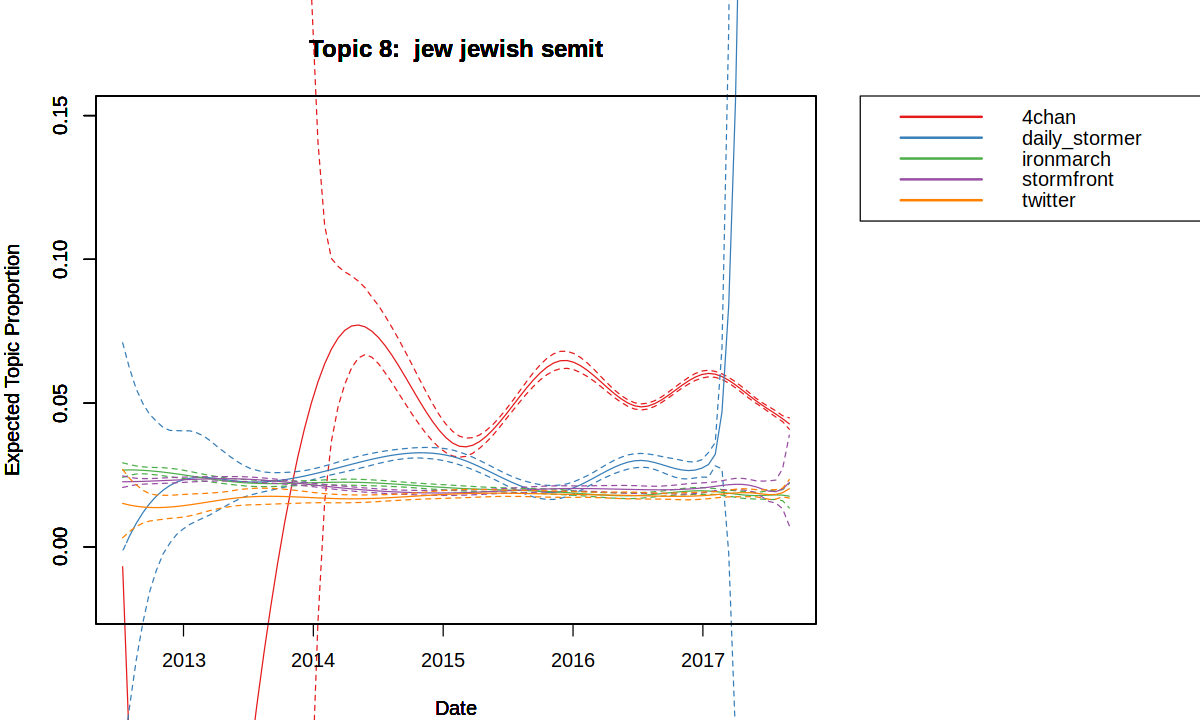

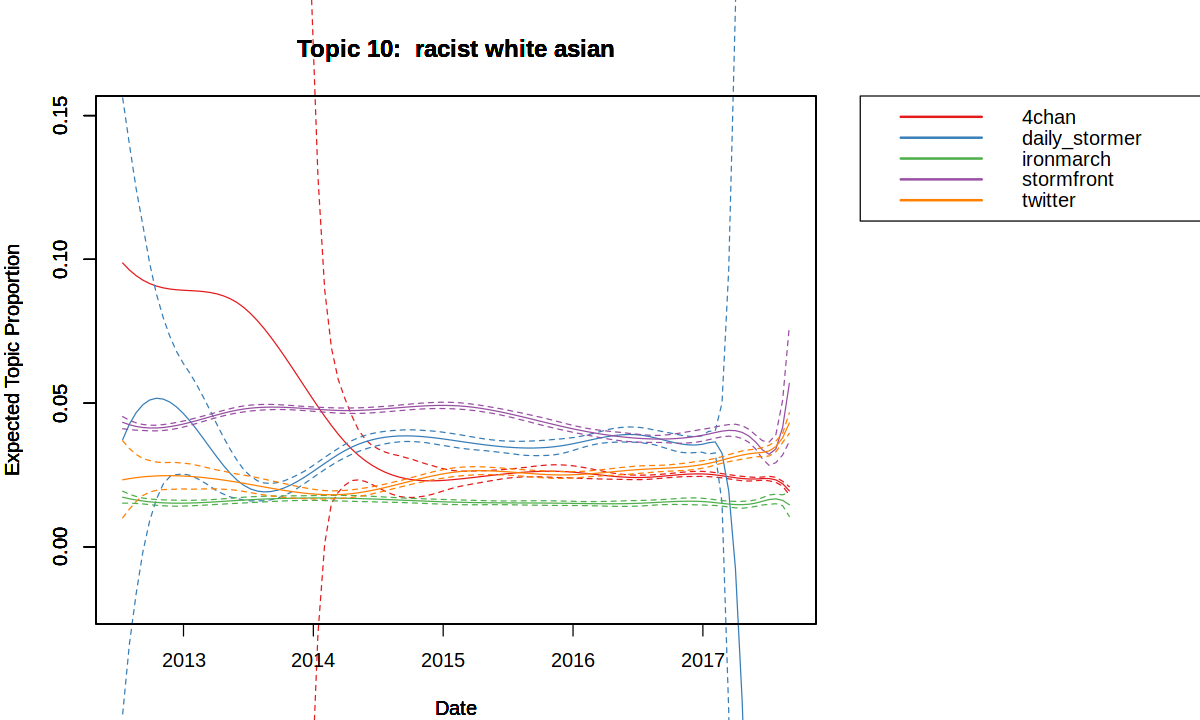

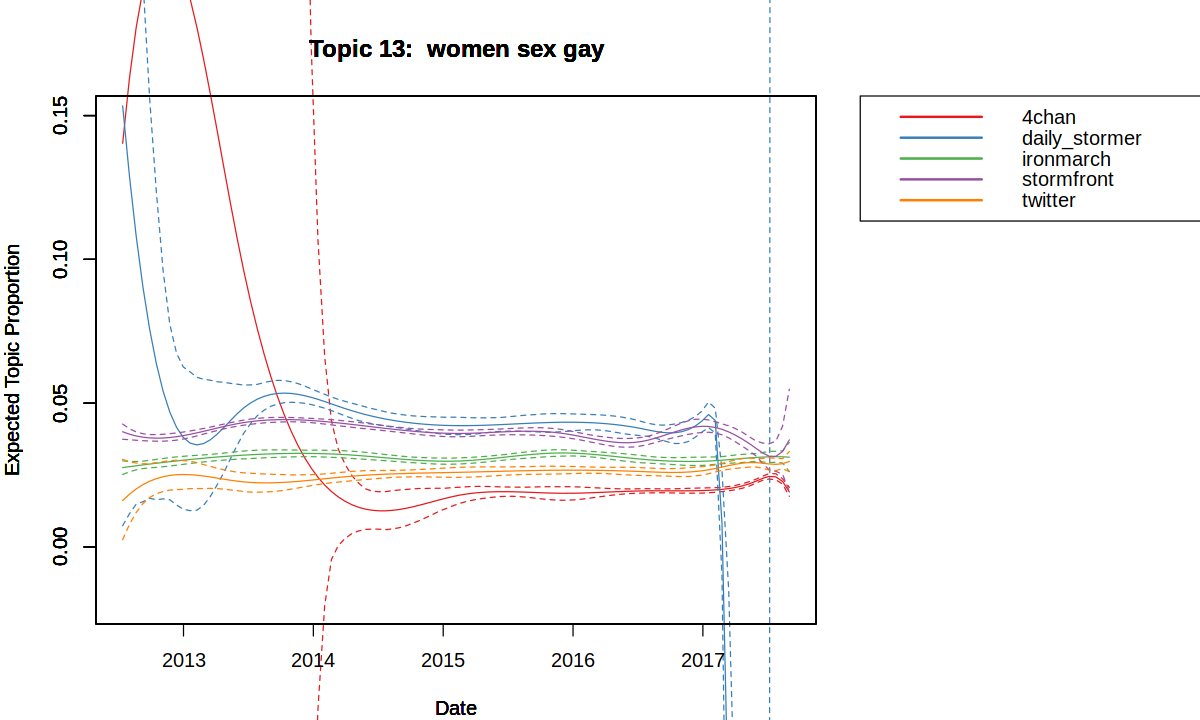

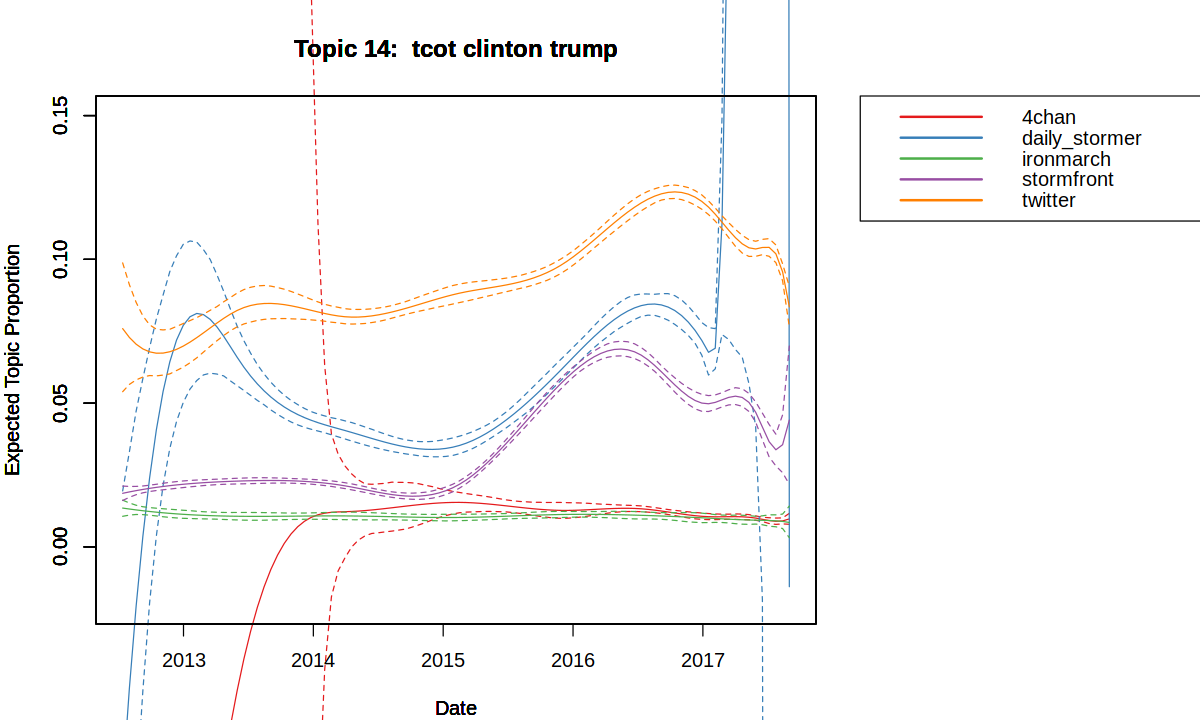

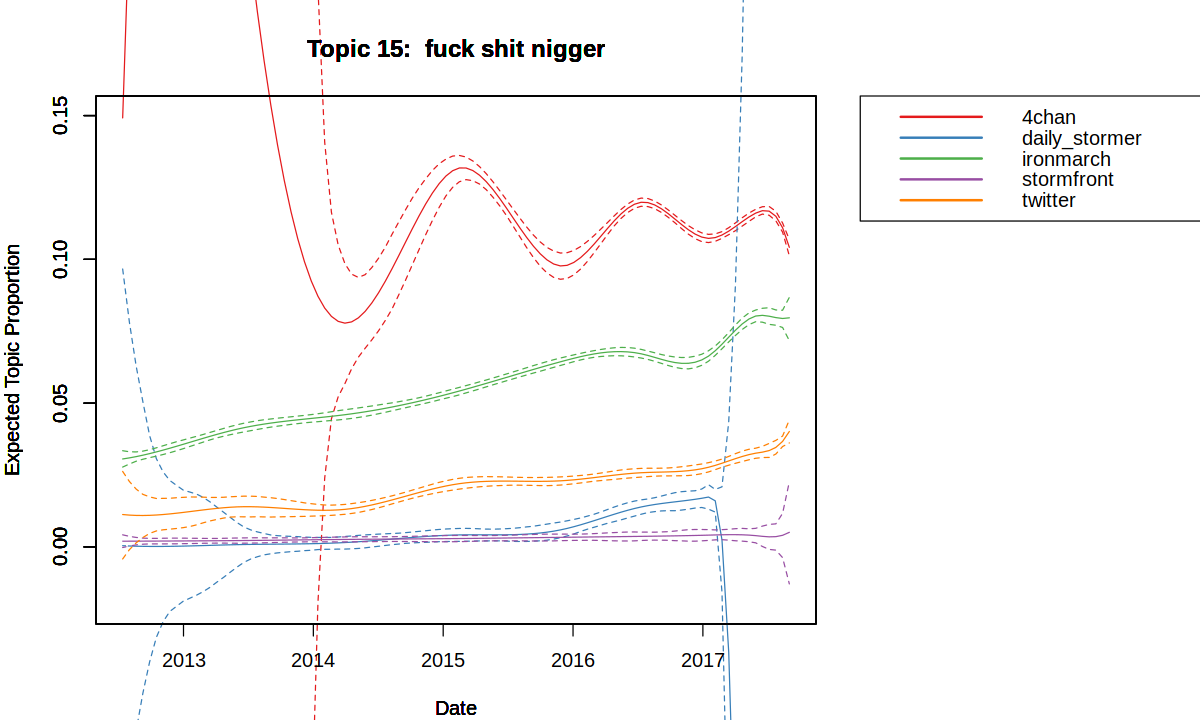

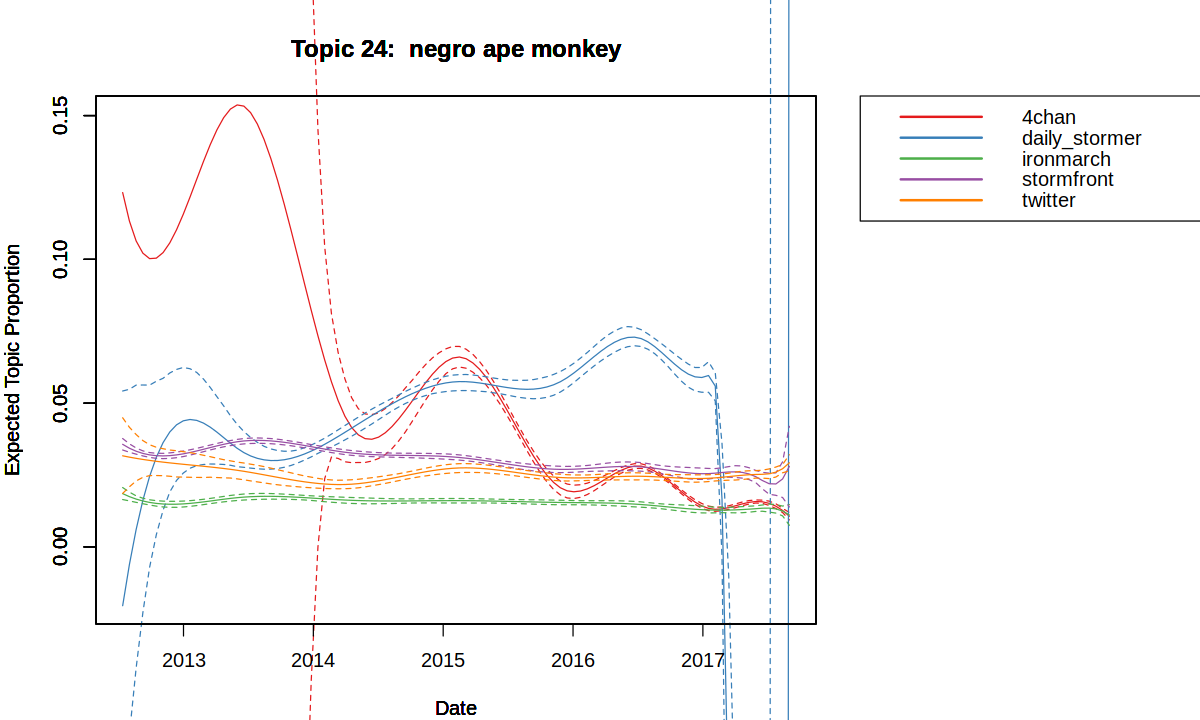

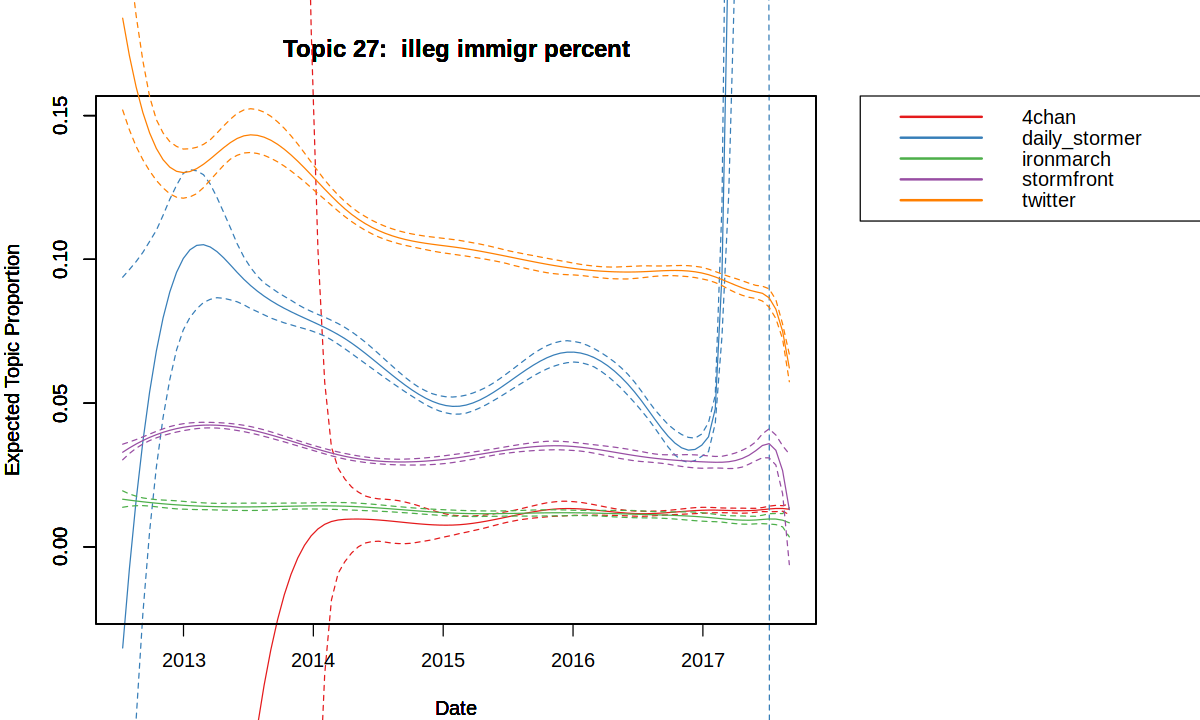

In [18]:
# Plot by topic
library(RColorBrewer)

# yearseq = 2002:2020
yearseq = 2013:2017
offset = as.integer(as.Date(sprintf('%s-01-01', min(yearseq))) - min(out$meta$date)) # to align the year ticks
# topic = 9
topics = c(2,8,10,13,14,15,24,27)
# topics = 1:num_topics

library('repr')
options(repr.plot.width=10, repr.plot.height=6)
par(mar = c(4, 4, 4, 16),                                  # Specify par parameters
    xpd = TRUE)
exclude_domains = c('discord', 'adl_heatmap') # too extreme
domains = levels(out$meta$source)
domains = domains[!domains %in% exclude_domains]

# palette = rainbow(length(domains)+1)
palette = brewer.pal(length(domains), name='Set1')

for (topic in topics) {
# for (topic in c(1)) {
    for (dataset in domains) {
        dataset_idx = which(domains == dataset)
        plot(effect, 
             model = model,
            covariate='day', 
            topics=topic,
            method = 'continuous', 
             moderator = 'source',
             moderator.value = dataset,
             main = sprintf('%s', topicnames[topic]),
             xlab='Date',
             xaxt = 'n',
             # ylim = c(-0.2, 0.4),
             ylim = c(0, 0.15),
             linecol = palette[[dataset_idx]],
             printlegend= FALSE
             )
        par(new=TRUE)
    }
        axis(1, at=((yearseq-min(yearseq))*365) + offset, labels=yearseq)
        legend("topright", inset=c(-0.7,0) , domains, lwd=2, col=palette)
}

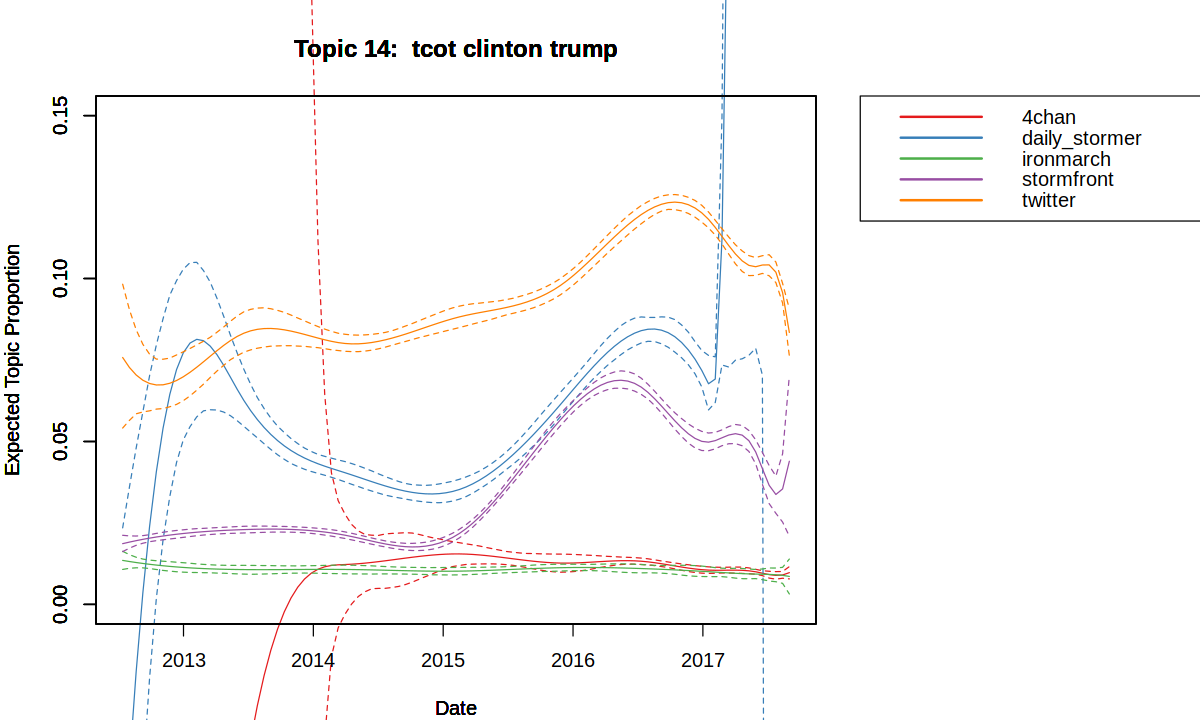

In [27]:
# Look at specific topics to copy over
yearseq = 2013:2017
offset = as.integer(as.Date(sprintf('%s-01-01', min(yearseq))) - min(out$meta$date)) # to align the year ticks
# topic = 9
topics = c(14)
# topics = 1:num_topics

library('repr')
options(repr.plot.width=10, repr.plot.height=6)
par(mar = c(4, 4, 4, 16),                                  # Specify par parameters
    xpd = TRUE)
exclude_domains = c('discord', 'adl_heatmap') # too extreme
domains = levels(out$meta$source)
domains = domains[!domains %in% exclude_domains]

# palette = rainbow(length(domains)+1)
palette = brewer.pal(length(domains), name='Set1')

for (topic in topics) {
# for (topic in c(1)) {
    for (dataset in domains) {
        dataset_idx = which(domains == dataset)
        plot(effect, 
             model = model,
            covariate='day', 
            topics=topic,
            method = 'continuous', 
             moderator = 'source',
             moderator.value = dataset,
             main = sprintf('%s', topicnames[topic]),
             xlab='Date',
             xaxt = 'n',
             # ylim = c(-0.2, 0.4),
             ylim = c(0, 0.15),
             linecol = palette[[dataset_idx]],
             printlegend= FALSE
             )
        par(new=TRUE)
    }
        axis(1, at=((yearseq-min(yearseq))*365) + offset, labels=yearseq)
        legend("topright", inset=c(-0.7,0) , domains, lwd=2, col=palette)
}

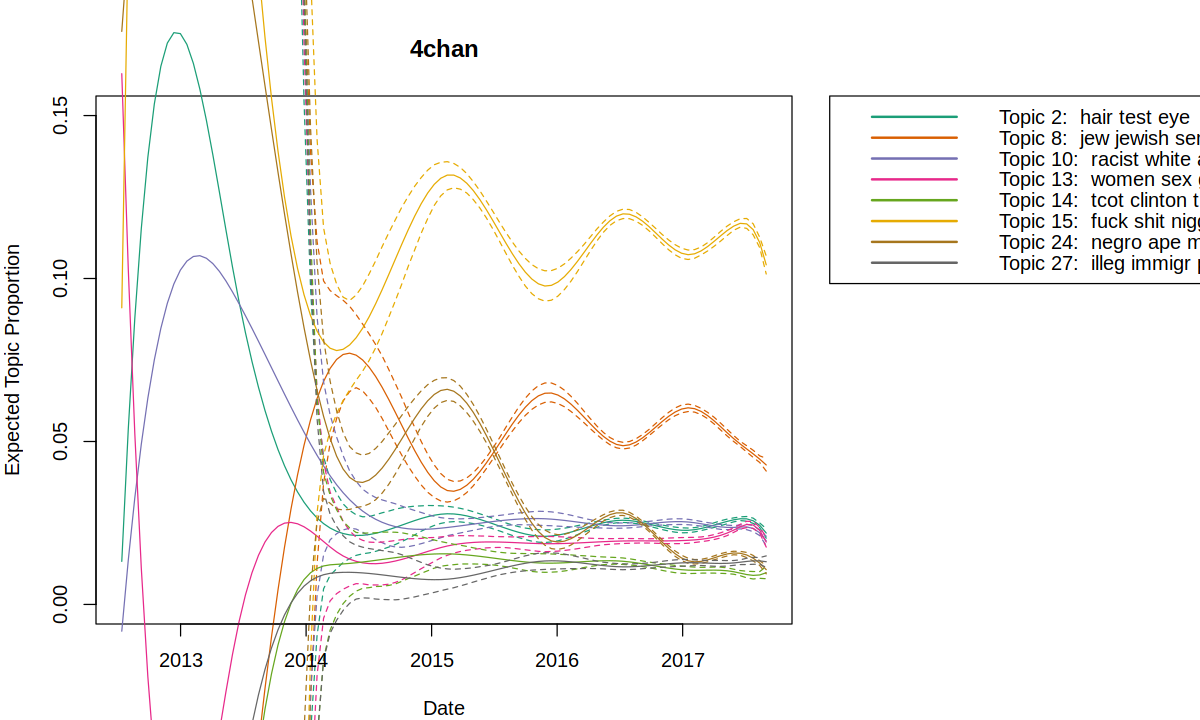

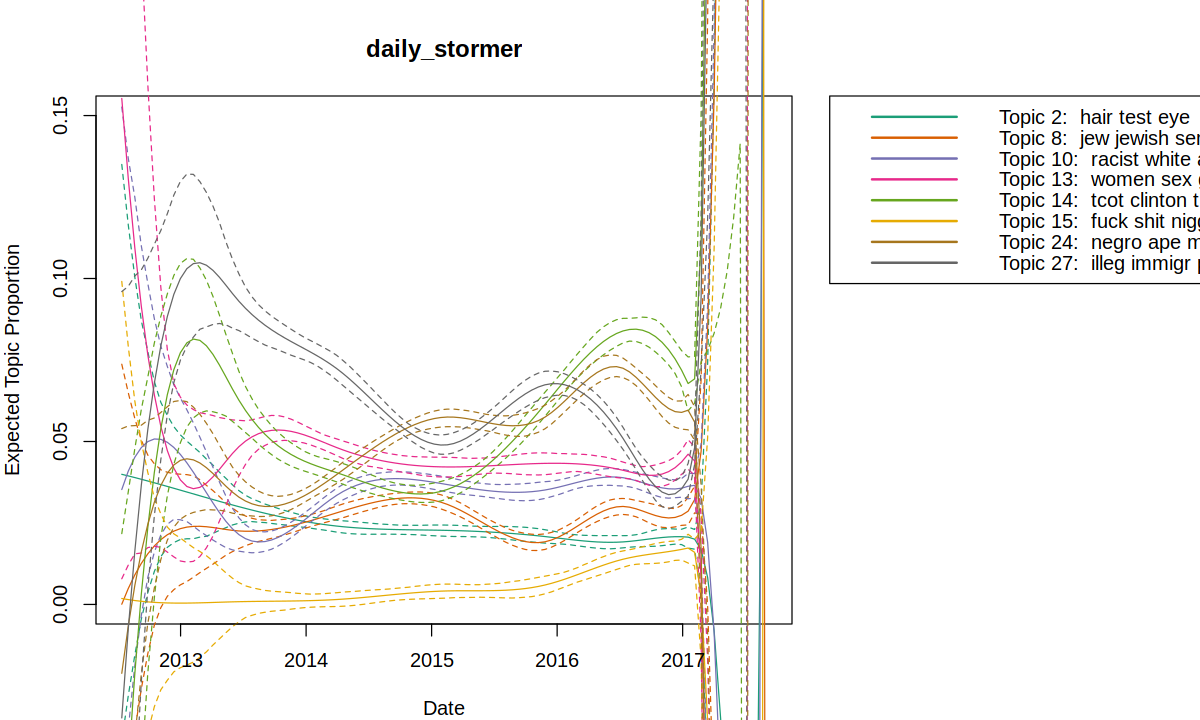

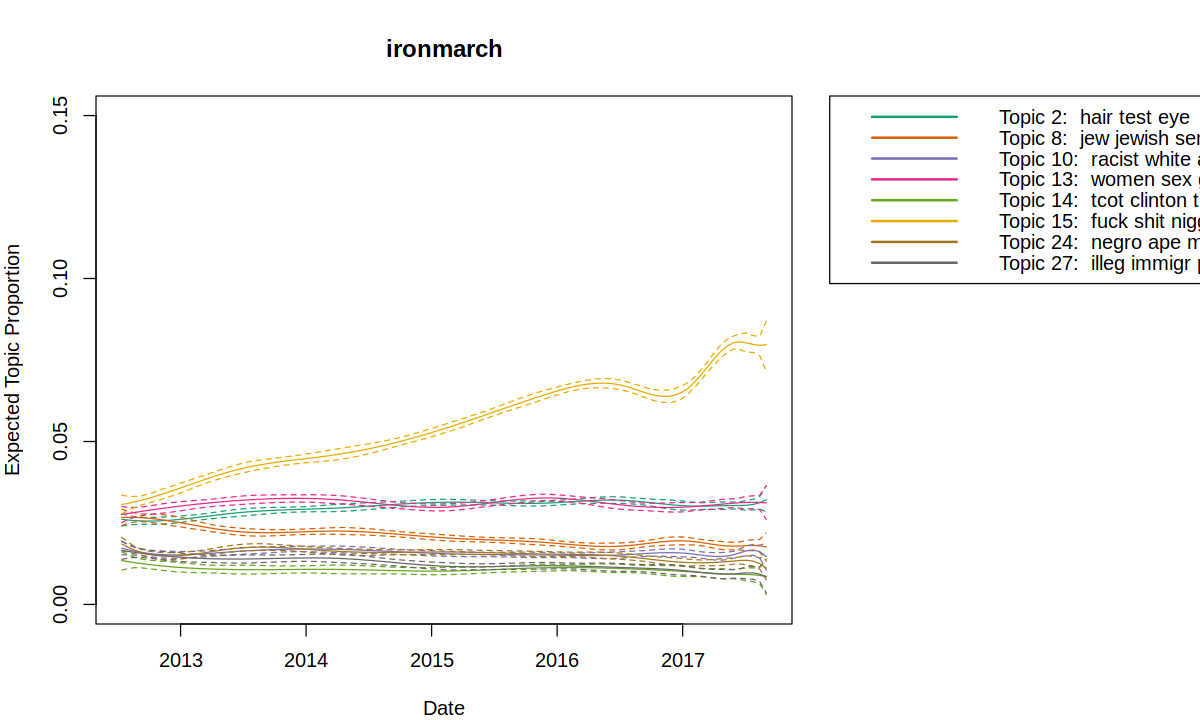

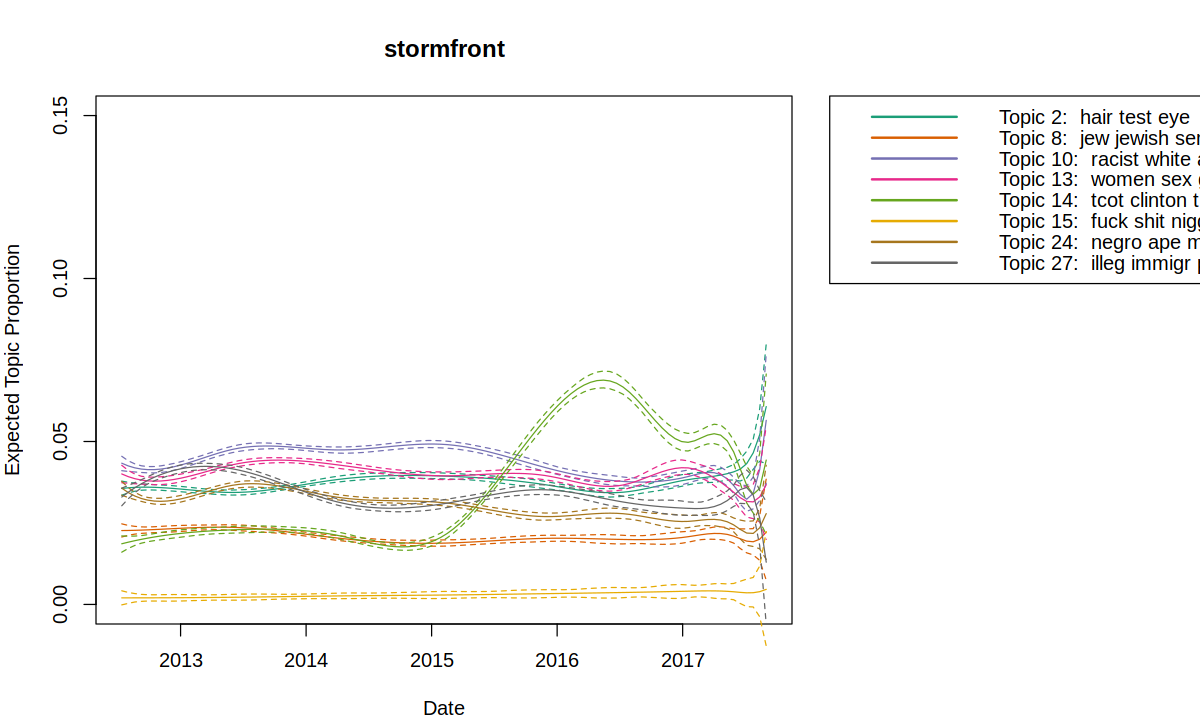

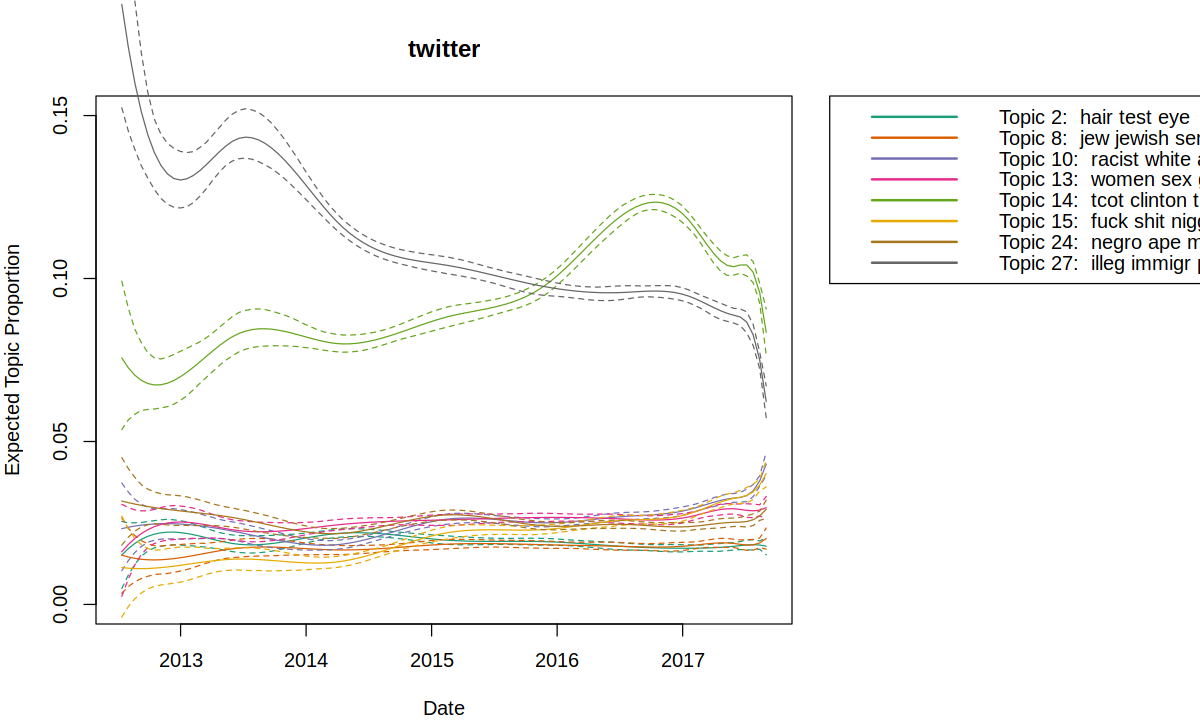

In [29]:
# Plot by dataset
library(RColorBrewer)

# yearseq = 2002:2020
yearseq = 2013:2017
offset = as.integer(as.Date(sprintf('%s-01-01', min(yearseq))) - min(out$meta$date)) # to align the year ticks
# topic = 9
topics = c(2,8,10,13,14,15,24,27)
# topics = 1:num_topics

library('repr')
options(repr.plot.width=10, repr.plot.height=6)
par(mar = c(4, 4, 4, 17),                                  # Specify par parameters
    xpd = TRUE)
exclude_domains = c('discord', 'adl_heatmap') # too extreme
domains = levels(out$meta$source)
domains = domains[!domains %in% exclude_domains]

# palette = rainbow(length(domains)+1)
palette = brewer.pal(length(topics), name='Dark2')

for (dataset in domains) {
    plot(effect, 
         model = model,
        covariate='day', 
        topics=topics,
        method = 'continuous', 
         moderator = 'source',
         moderator.value = dataset,
         main = dataset,
         xlab='Date',
         xaxt = 'n',
         # ylim = c(-0.2, 0.4),
         ylim = c(0, 0.15),
         linecol = palette,
         printlegend= FALSE
         )
        axis(1, at=((yearseq-min(yearseq))*365) + offset, labels=yearseq)
        legend("topright", inset=c(-1.24,0) , topicnames[topics], lwd=2, col=palette)
}

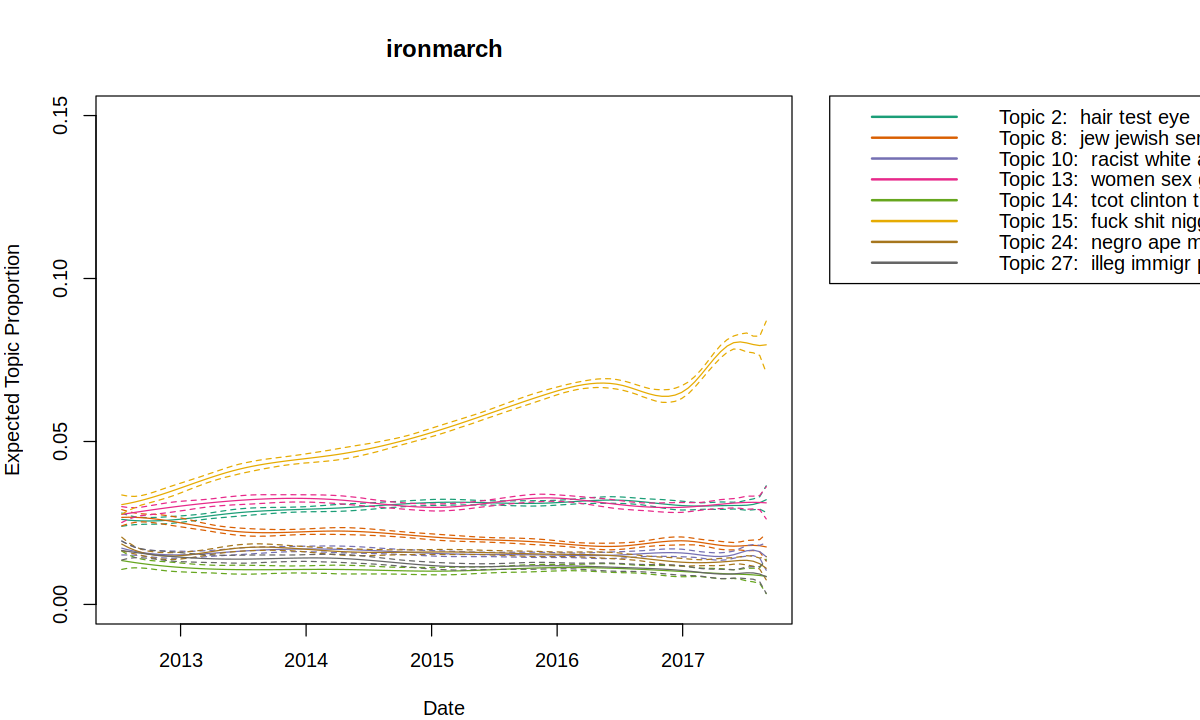

In [34]:
# Plot by dataset (individually to copy over)
library(RColorBrewer)

# yearseq = 2002:2020
yearseq = 2013:2017
offset = as.integer(as.Date(sprintf('%s-01-01', min(yearseq))) - min(out$meta$date)) # to align the year ticks
# topic = 9
topics = c(2,8,10,13,14,15,24,27)
# topics = 1:num_topics

library('repr')
options(repr.plot.width=10, repr.plot.height=6)
par(mar = c(4, 4, 4, 17),                                  # Specify par parameters
    xpd = TRUE)
exclude_domains = c('discord', 'adl_heatmap') # too extreme
domains = c('ironmarch')

# palette = rainbow(length(domains)+1)
palette = brewer.pal(length(topics), name='Dark2')

for (dataset in domains) {
    plot(effect, 
         model = model,
        covariate='day', 
        topics=topics,
        method = 'continuous', 
         moderator = 'source',
         moderator.value = dataset,
         main = dataset,
         xlab='Date',
         xaxt = 'n',
         # ylim = c(-0.2, 0.4),
         ylim = c(0, 0.15),
         linecol = palette,
         printlegend= FALSE
         )
        axis(1, at=((yearseq-min(yearseq))*365) + offset, labels=yearseq)
        legend("topright", inset=c(-1.24,0) , topicnames[topics], lwd=2, col=palette)
}

## Plot effects of dataset

In [ ]:
# Plot effects of dataset across topics, save out info to do this in Python
library('rjson')
plot_cov = 'source'
out_dirpath = sprintf('../tmp/%s_%s_%dtopics_%dit_%dmindf_%s_plots', corpus_name, covariates_str, num_topics, max_iters, min_df, plot_cov) 
dir.create(out_dirpath)

for (topic_num in 1:num_topics) {
    p <- plot(effect, 
             covariate=plot_cov,
             topics=c(topic_num),
             model = model,
             method = 'pointestimate',
             # main = sprintf('Effect of source topic %s prevalence', topicnames[topic_num]),
             # xlim = c(0.01, .25),
             # ylim = c(-0.5,2.5),
             # labeltype = 'custom',
             # cex.main = 1.1,
             # custom.labels = c(
             #     'hi_lgbtq: LGBTQ characters',
             #     'lo_lgbtq: LGBTQ characters'
             #     )
            )
    jsondata = toJSON(p)
    json_path <- file.path(out_dirpath, sprintf('%d_plot.json', topic_num))
    write(jsondata, json_path)
    }

## Plot effects of visibility

In [ ]:
# Plot effects of visibility across topics, save out info to do this in Python
library('rjson')
plot_cov = 'visibility'
out_dirpath = sprintf('../tmp/%s_%s_%dtopics_%dit_%dmindf_%s_plots', corpus_name, covariates_str, num_topics, max_iters, min_df, plot_cov) 
dir.create(out_dirpath)

for (topic_num in 1:num_topics) {
    p <- plot(effect, 
             covariate=plot_cov,
             topics=c(topic_num),
             model = model,
             method = 'pointestimate',
             # main = sprintf('Effect of source topic %s prevalence', topicnames[topic_num]),
             # xlim = c(0.01, .25),
             # ylim = c(-0.5,2.5),
             # labeltype = 'custom',
             # cex.main = 1.1,
             # custom.labels = c(
             #     'hi_lgbtq: LGBTQ characters',
             #     'lo_lgbtq: LGBTQ characters'
             #     )
            )
    jsondata = toJSON(p)
    json_path <- file.path(out_dirpath, sprintf('%d_plot.json', topic_num))
    write(jsondata, json_path)
    }

## Plot effects of day x visibility

In [ ]:
# Plot by topic
library(RColorBrewer)

# yearseq = 2002:2020
yearseq = 2013:2017
offset = as.integer(as.Date(sprintf('%s-01-01', min(yearseq))) - min(out$meta$date)) # to align the year ticks
# topic = 9
topics = c(2,8,10,13,14,15,24,27)
# topics = 1:num_topics

library('repr')
options(repr.plot.width=10, repr.plot.height=6)
par(mar = c(4, 4, 4, 16),                                  # Specify par parameters
    xpd = TRUE)
exclude_domains = c('discord', 'adl_heatmap') # too extreme
visibilities = levels(out$meta$visibility)

# palette = rainbow(length(domains)+1)
palette = brewer.pal(length(visibilities), name='Set1')

for (topic in topics) {
# for (topic in c(1)) {
    for (vis in visibilities) {
        vis_idx = which(visibilities == vis)
        plot(effect, 
             model = model,
            covariate='day', 
            topics=topic,
            method = 'continuous', 
             moderator = 'visibility',
             moderator.value = vis,
             main = sprintf('%s', topicnames[topic]),
             xlab='Date',
             xaxt = 'n',
             # ylim = c(-0.2, 0.4),
             ylim = c(0, 0.15),
             linecol = palette[[vis_idx]],
             printlegend= FALSE
             )
        par(new=TRUE)
    }
        axis(1, at=((yearseq-min(yearseq))*365) + offset, labels=yearseq)
        legend("topright", inset=c(-0.5,0) , visibilities, lwd=2, col=palette)
}

Warning message in brewer.pal(length(visibilities), name = "Set1"):
“minimal value for n is 3, returning requested palette with 3 different levels
”


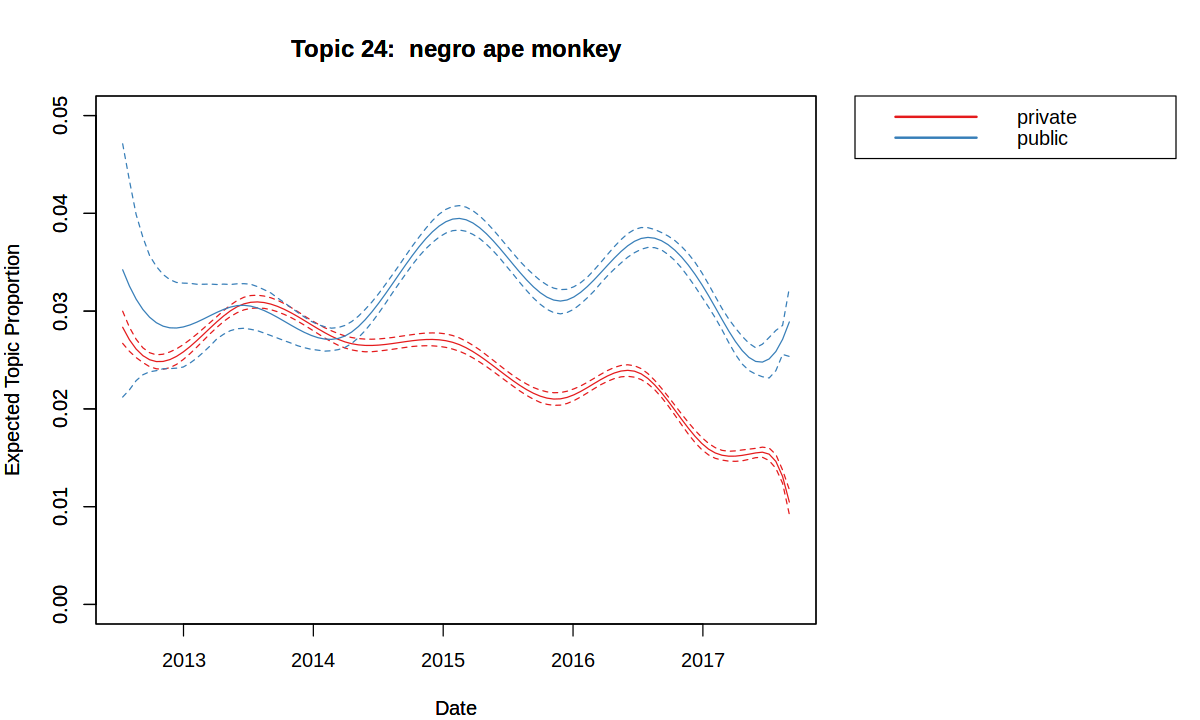

In [51]:
# Plot by topic (individual for copying)
library(RColorBrewer)

# yearseq = 2002:2020
yearseq = 2013:2017
offset = as.integer(as.Date(sprintf('%s-01-01', min(yearseq))) - min(out$meta$date)) # to align the year ticks
# topic = 9
topics = c(24)
# topics = 1:num_topics

library('repr')
options(repr.plot.width=10, repr.plot.height=6)
par(mar = c(4, 4, 4, 16),                                  # Specify par parameters
    xpd = TRUE)
exclude_domains = c('discord', 'adl_heatmap') # too extreme
visibilities = levels(out$meta$visibility)

# palette = rainbow(length(domains)+1)
palette = brewer.pal(length(visibilities), name='Set1')

for (topic in topics) {
# for (topic in c(1)) {
    for (vis in visibilities) {
        vis_idx = which(visibilities == vis)
        plot(effect, 
             model = model,
            covariate='day', 
            topics=topic,
            method = 'continuous', 
             moderator = 'visibility',
             moderator.value = vis,
             main = sprintf('%s', topicnames[topic]),
             xlab='Date',
             xaxt = 'n',
             # ylim = c(-0.2, 0.4),
             ylim = c(0, 0.05),
             linecol = palette[[vis_idx]],
             printlegend= FALSE
             )
        par(new=TRUE)
    }
        axis(1, at=((yearseq-min(yearseq))*365) + offset, labels=yearseq)
        legend("topright", inset=c(-0.5,0) , visibilities, lwd=2, col=palette)
}

# Document-topic matrix

In [16]:
# Load model
corpus_name <- 'white_supremacist_users_2012-07-14_thru_2017-08-31'
num_topics <- 100
max_iters <- 100
do_stem <- TRUE
min_df <- 100 # minimum document frequency for words
covariates_str <- 'sourcexday'

path <- sprintf('../models/%s_stm_%s_%dtopics_%dit_%dmindf.rds', corpus_name, covariates_str, num_topics, max_iters, min_df)
# path <- sprintf('../models/%s_orig_stm_%s_%dtopics_%dit_%dmindf.rds', corpus_name, covariates_str, num_topics, max_iters, min_df)
model <- readRDS(path)

## Save out as is
For calculating topic similarity for clustering without needing document names

In [17]:
dim(model$theta)

[1] 547046    100

In [ ]:
model$theta

In [21]:
# topic_str = paste('topic', 1:30, sep='')

doc_topics = as.data.frame(model$theta)
doc_topics = setNames(doc_topics, 1:num_topics)
doc_topics

1,2,3,4,5,6,7,8,9,10,⋯,91,92,93,94,95,96,97,98,99,100
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0.0020204460,0.006369646,0.008226574,0.007117062,0.01298519,0.0029151286,0.019194972,0.002594459,0.009410998,0.005446481,⋯,0.011624267,0.005512170,0.0010434970,0.0035351345,0.002723805,0.002504033,0.005422156,0.015244733,0.004637782,0.005106584
0.0016064467,0.002928382,0.015273419,0.004881452,0.01460242,0.0053593049,0.011822379,0.003076879,0.027527390,0.003031777,⋯,0.009138449,0.005921447,0.0028266996,0.0055095124,0.003824038,0.002112869,0.002645052,0.017373522,0.006192654,0.004385999
0.0022199349,0.004190346,0.017663666,0.004590420,0.03334520,0.0021354635,0.007285637,0.006617668,0.012214653,0.005931605,⋯,0.033258221,0.010908169,0.0021492647,0.0026115716,0.005120280,0.005913089,0.002915706,0.009594115,0.002312083,0.005935811
0.0026515735,0.004699609,0.006558036,0.005769275,0.01773403,0.0015920391,0.008786609,0.004075117,0.007477030,0.005974467,⋯,0.009000391,0.015793727,0.0009738025,0.0015157944,0.003663637,0.005729708,0.003376370,0.016198260,0.002874898,0.005637759
0.0029734815,0.004031919,0.013653715,0.008741847,0.01888947,0.0037679860,0.008816317,0.003651953,0.027118764,0.004538731,⋯,0.007305686,0.010787489,0.0013854249,0.0049070472,0.004072209,0.004752179,0.002983464,0.025497346,0.008963422,0.005289802
0.0009843637,0.004027589,0.005078477,0.003231023,0.01766614,0.0010508952,0.005168574,0.004776084,0.007446629,0.013412818,⋯,0.005423532,0.016003654,0.0015963951,0.0007947057,0.002360557,0.005827929,0.002258919,0.011859941,0.002628265,0.004350709
0.0018948419,0.003746406,0.003714035,0.006334430,0.01620100,0.0008341311,0.004032420,0.007119369,0.002795537,0.012507389,⋯,0.005978674,0.098219984,0.0005807841,0.0017835037,0.001899888,0.010515929,0.001557518,0.009772666,0.004325758,0.004520155
0.0013067086,0.006086817,0.011991816,0.005132311,0.02814866,0.0018003395,0.005870187,0.006807035,0.009219097,0.005374369,⋯,0.008695411,0.011820502,0.0018964444,0.0023706259,0.004986337,0.006033951,0.003034889,0.010884571,0.002979328,0.005826487
0.0058089688,0.005259623,0.007244377,0.008965506,0.01838962,0.0028909528,0.008558364,0.003081727,0.006781790,0.005786797,⋯,0.014639320,0.011724627,0.0010139866,0.0024934590,0.003487639,0.003569799,0.003290826,0.016898407,0.005810063,0.006002607


In [22]:
# Save out
corpus_name <- 'white_supremacist_users_2012-07-14_thru_2017-08-31'
path <- sprintf('../tmp/%s_%s_%dtopics_%dit_%dmindf_doc_topics.csv', corpus_name, covariates_str, num_topics, max_iters, min_df)
write.csv(doc_topics, path)
path

[1] "../tmp/white_supremacist_users_2012-07-14_thru_2017-08-31_sourcexday_100topics_100it_100mindf_doc_topics.csv"

## Save out with original topic names
For calculating user topic use

In [2]:
# Load processed docs
out <- readRDS('../tmp/processed_%s.rds', corpus_name)

In [25]:
length(out$meta$id)

[1] 547046

In [26]:
dim(model$theta)

[1] 547046     30

In [28]:
# topic_str = paste('topic', 1:30, sep='')

doc_topics = as.data.frame(model$theta, row.names=out$meta$id)
# doc_topics = setNames(doc_topics, topic_str)
doc_topics = setNames(doc_topics, 1:num_topics)
doc_topics

,1,2,3,4,5,6,7,8,9,10,⋯,21,22,23,24,25,26,27,28,29,30
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
qian2018_0,0.02690452,0.02400024,0.003806121,0.00728391,0.01179853,0.005989596,0.098334223,0.003401977,0.02025328,0.004259059,⋯,0.02375181,0.002035222,0.007645491,0.012397648,0.004103334,0.04033507,0.02259416,0.04075368,0.003474057,0.008764309
qian2018_1,0.02919631,0.01323255,0.021016502,0.01083748,0.01357300,0.008877172,0.073838050,0.010816058,0.01217683,0.007861692,⋯,0.14789208,0.002729618,0.011442202,0.011136489,0.005732235,0.03301976,0.02584345,0.21267009,0.010682241,0.010183737
qian2018_2,0.02910796,0.01351262,0.009845687,0.02262378,0.06236796,0.007515228,0.017622694,0.016423792,0.03150458,0.018807992,⋯,0.02729357,0.002773148,0.019558124,0.011827551,0.016828335,0.07351117,0.10804944,0.02923848,0.009077820,0.013604310
qian2018_3,0.03825198,0.01305614,0.003417589,0.03234031,0.01456651,0.007539502,0.013659475,0.011546439,0.02997516,0.087934328,⋯,0.02186973,0.002126553,0.013982910,0.082514742,0.013152417,0.06394051,0.17969360,0.01832234,0.007525947,0.008814776
qian2018_4,0.06266491,0.02043494,0.008735335,0.02899670,0.02367131,0.014865624,0.049537947,0.013091806,0.02615599,0.012826433,⋯,0.11473098,0.003514827,0.013555641,0.021384379,0.010848273,0.06200565,0.08437735,0.05520101,0.011446684,0.014712094
qian2018_5,0.02410672,0.00893329,0.005512290,0.02307268,0.01327055,0.006966534,0.008423761,0.015654754,0.03800544,0.022113965,⋯,0.01681691,0.002450072,0.021052531,0.009801006,0.017343936,0.10538077,0.17690722,0.01621639,0.009863229,0.011878368
qian2018_6,0.02684386,0.01789970,0.005094432,0.03867427,0.01394491,0.041859846,0.018515148,0.015706549,0.11380405,0.017777696,⋯,0.03206630,0.003630807,0.033377602,0.040017702,0.012361944,0.07623092,0.06965295,0.01678678,0.008011356,0.010201761
qian2018_7,0.18004659,0.01108490,0.006480265,0.02319645,0.03591949,0.007272227,0.012328796,0.016897076,0.03532336,0.027667372,⋯,0.01507881,0.002286637,0.019537441,0.011932782,0.029331832,0.07022696,0.13895380,0.01601492,0.008920356,0.013596747
qian2018_8,0.03691635,0.02907781,0.005940037,0.02342487,0.01291924,0.009241210,0.026201007,0.004383060,0.03352884,0.011250488,⋯,0.02424706,0.002219430,0.011535537,0.018208300,0.007596153,0.05461817,0.06099851,0.01882747,0.006044772,0.008703384


In [29]:
# Save out
corpus_name <- 'white_supremacist_users_2012-07-14_thru_2017-08-31'
path <- sprintf('../tmp/%s_%s_%dtopics_%dit_%dmindf_doc_topics.csv', corpus_name, covariates_str, num_topics, max_iters, min_df)
write.csv(doc_topics, path, row.names = TRUE)

path